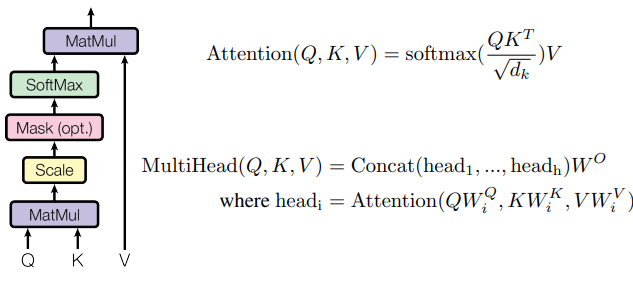

In [1]:
from IPython.display import Image
Image(filename='./samples/attention_formula.png')

# 1. model config and load

In [3]:
import torch
from torch import nn
import math
from bertviz.transformers_neuron_view import BertModel, BertConfig
from transformers import BertTokenizer

In [4]:
max_length = 256
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name, output_attentions=True,
                                    output_hidden_states=True,
                                    return_dict=True)

tokenizer = BertTokenizer.from_pretrained(model_name)
config.max_position_embeddings = max_length

model = BertModel.from_pretrained(model_name)
model = model.eval()

100%|██████████████████████████████████████████████████████████████| 440473133/440473133 [00:51<00:00, 8553297.05B/s]


In [6]:
att_head_size = int(model.config.hidden_size/model.config.num_attention_heads)

model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

# 2. data

In [16]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
inputs_tests = tokenizer(newsgroups_train['data'][:1],
                         truncation=True, padding=True, max_length=max_length,
                         return_tensors='pt')

In [20]:
list(inputs_tests.keys())
inputs_tests['attention_mask'].shape

torch.Size([1, 201])

# 3. model output

In [21]:
model_output = model(**inputs_tests)

- last_hidden_state (batch_size, sequence_length, hidden_size) : last hidden state which is outputted from the last BertLayer
- pooler_output (batch_size, hidden_size) : output of the Pooler layer
- hidden_states (batch_size, sequence_length, hidden_size): hidden-states of the model at the output of each BertLayer plus the initial embedding
- attentions (batch_size, num_heads, sequence_length, sequence_length): one for each BertLayer. Attentions weights after the attention SoftMax

In [27]:
model_output[-1][0].keys() # The first layer of encoder

dict_keys(['attn', 'queries', 'keys'])

In [35]:
model_output[-1][0]['attn'].shape, model_output[-1][0]['attn'][0, 0, :, :]

(torch.Size([1, 12, 201, 201]),
 tensor([[0.0053, 0.0109, 0.0052,  ..., 0.0039, 0.0036, 0.0144],
         [0.0086, 0.0041, 0.0125,  ..., 0.0045, 0.0041, 0.0071],
         [0.0051, 0.0043, 0.0046,  ..., 0.0043, 0.0045, 0.0031],
         ...,
         [0.0010, 0.0023, 0.0055,  ..., 0.0012, 0.0018, 0.0011],
         [0.0010, 0.0023, 0.0057,  ..., 0.0012, 0.0017, 0.0007],
         [0.0022, 0.0056, 0.0063,  ..., 0.0045, 0.0048, 0.0015]],
        grad_fn=<SliceBackward0>))

# 4. from scratch

In [40]:
list(inputs_tests.keys())

['input_ids', 'token_type_ids', 'attention_mask']

In [41]:
emb_output = model.embeddings(inputs_tests['input_ids'], inputs_tests['token_type_ids'])

In [61]:
emb_output.shape, model.encoder.layer[0], model.encoder.layer[0].attention.self.query

(torch.Size([1, 201, 768]),
 BertLayer(
   (attention): BertAttention(
     (self): BertSelfAttention(
       (query): Linear(in_features=768, out_features=768, bias=True)
       (key): Linear(in_features=768, out_features=768, bias=True)
       (value): Linear(in_features=768, out_features=768, bias=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (output): BertSelfOutput(
       (dense): Linear(in_features=768, out_features=768, bias=True)
       (LayerNorm): BertLayerNorm()
       (dropout): Dropout(p=0.1, inplace=False)
     )
   )
   (intermediate): BertIntermediate(
     (dense): Linear(in_features=768, out_features=3072, bias=True)
   )
   (output): BertOutput(
     (dense): Linear(in_features=3072, out_features=768, bias=True)
     (LayerNorm): BertLayerNorm()
     (dropout): Dropout(p=0.1, inplace=False)
   )
 ),
 Linear(in_features=768, out_features=768, bias=True))

In [44]:
# emb_output[0].shape -> 201*768
# query.weight.T[:, :att_head_size]: 768*64
# 201*64
Q_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.query.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.query.bias[:att_head_size]

In [45]:
# emb_output[0].shape -> 201*768
# key.weight.T[:, :att_head_size]: 768*64
# 201*64
K_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.key.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.key.bias[:att_head_size]

In [49]:
# (201*64)*(64*201) ==> 201*201
attn_scores = torch.nn.Softmax(dim=-1)(
    Q_first_head_first_layer @ K_first_head_first_layer.T / math.sqrt(att_head_size))

In [123]:
attn_scores

tensor([[0.0053, 0.0109, 0.0052,  ..., 0.0039, 0.0036, 0.0144],
        [0.0086, 0.0041, 0.0125,  ..., 0.0045, 0.0041, 0.0071],
        [0.0051, 0.0043, 0.0046,  ..., 0.0043, 0.0045, 0.0031],
        ...,
        [0.0010, 0.0023, 0.0055,  ..., 0.0012, 0.0018, 0.0011],
        [0.0010, 0.0023, 0.0057,  ..., 0.0012, 0.0017, 0.0007],
        [0.0022, 0.0056, 0.0063,  ..., 0.0045, 0.0048, 0.0015]],
       grad_fn=<SoftmaxBackward0>)

In [52]:
V_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.value.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.value.bias[:att_head_size]

In [53]:
attn_emb = attn_scores @ V_first_head_first_layer

In [54]:
attn_emb.shape

torch.Size([201, 64])

### Try again:

In [121]:
emb_output = model.embeddings(inputs_tests['input_ids'], inputs_tests['token_type_ids'])

query = emb_output[0] @ model.encoder.layer[0].attention.self.query.weight[:att_head_size].T \
                        + model.encoder.layer[0].attention.self.query.bias[:att_head_size]
key = emb_output[0] @ model.encoder.layer[0].attention.self.key.weight[:att_head_size].T \
                        + model.encoder.layer[0].attention.self.key.bias[:att_head_size]

attn_score = torch.nn.Softmax(dim=-1)(query @ key.T / math.sqrt(att_head_size))

attn_score

tensor([[0.0053, 0.0109, 0.0052,  ..., 0.0039, 0.0036, 0.0144],
        [0.0086, 0.0041, 0.0125,  ..., 0.0045, 0.0041, 0.0071],
        [0.0051, 0.0043, 0.0046,  ..., 0.0043, 0.0045, 0.0031],
        ...,
        [0.0010, 0.0023, 0.0055,  ..., 0.0012, 0.0018, 0.0011],
        [0.0010, 0.0023, 0.0057,  ..., 0.0012, 0.0017, 0.0007],
        [0.0022, 0.0056, 0.0063,  ..., 0.0045, 0.0048, 0.0015]],
       grad_fn=<SoftmaxBackward0>)